This is a set of models trained on the MNIST handwriting [dataset](http://yann.lecun.com/exdb/mnist/). They increase in effectiveness and complexity, but interestingly the very simple first model - a logistic regression - gives pretty accurate results. 

This was done as part of a [Kaggle training exercise](https://www.kaggle.com/c/digit-recognizer). 

In [12]:
sample_fraction=.1
image_size = 28

In [13]:
import pandas as pd

train = pd.read_csv('train.csv')

smaller_sample = train.sample(frac=sample_fraction, random_state=5)
X = smaller_sample.drop('label', axis='columns')
y = smaller_sample['label']

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)
X_train.shape, X_test.shape

((3150, 784), (1050, 784))

Display a randomly selected digit so that we know what we are dealing with. The data as supplied here is flat - the 28 x 28 matrix has been unrolled into a 784 long row. This is fine for the simpler models, but we will need to reconstruct the images for the Convolutional Neural Networks later. We reconstruct our randomly selected one here for display by matplotlib.

label is 0


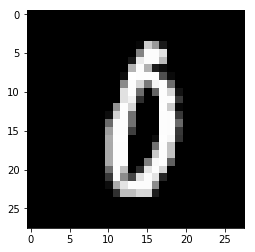

In [15]:
import matplotlib.pyplot as plt
import random
def show_digit(index):
    print('label is {}'.format(y.iloc[index]))
    plt.imshow(X.iloc[index].values.reshape(image_size,-1), cmap='gray')
    plt.show()
show_digit(random.randint(0,len(X)))

## Logistic Regression

In [27]:
from sklearn.linear_model import LogisticRegression
from time import perf_counter as pc

lr = LogisticRegression(solver='lbfgs', max_iter=10000, multi_class='multinomial')

t0 = pc()
lr.fit(X_train, y_train)
print('elapsed time {:.2f} s'.format(pc() - t0))

elapsed time 12.37 s


In [28]:
'accuracy is {:.3f}'.format(lr.score(X_test, y_test))

'accuracy is 0.863'

The first time I did a Logistic Regression on this data I was surprised that it worked at all. This means that a pixel by pixel correspondence between different handwritten version of the same digit gives a good model. In a previous notebook I went on to use a deskew function to straighten all of the images up prior to training. This gives a beter liklihood that of pixel by pixel correspondence and gave even better results, but I am not going to bother with that here as we are moving on to much better models.

Prior to generating results in the correct format for submission to Kaggle we retrain the model with the full (sampled in this case) dataset. For a real competition run you would change the `sample_fraction` value at the top of the notebook to `1`.

In [29]:
t0 = pc()
lr.fit(X, y)
print('elapsed time {:.2f}'.format(pc() - t0))

elapsed time 19.16


This function writes the csv file that Kaggle requires. It is very useful to have this as part of your pipeline from early on in a project so that you can see if everything keeps working as you iterate. It behaves slightly differently for the different networks, but that should be self explanatory. Once you have done this just upload `output.csv` to Kaggle.

In [102]:
def generate_results(model, type='non-nn'):
    test = pd.read_csv('test.csv')
    
    if type=='nn':
        result = model.predict(test.values/255)
        result = np.argmax(result, axis=1)
    elif type=='cnn':
        result = model.predict(np.expand_dims((test.values/255).reshape(-1, 28, 28), axis=3))
        result = np.argmax(result, axis=1)
    else:
        result = model.predict(test)
        
    with open('output.csv', 'w') as output:
        output.write('ImageId,Label\n')
        for a in zip(np.array(test.index)+1, result):
            output.writelines(str(a[0]) + ","+ str(a[1])+'\n')

In [269]:
generate_results(lr)

## Neural network

On the original data [website](http://yann.lecun.com/exdb/mnist/) from Yann Le Cunn you can find a table of previous results on this dataset. The model below is just a normal feedforward neural network with no convolutions or dropout. It is based on one of the deeper networks in that table. 
It gives very good results with a validation accuracy of 92.6%.

In [32]:
from tensorflow.keras.utils import to_categorical
X_train_nn = X_train.values/255
X_test_nn = X_test.values/255

y_train_cat = to_categorical(y_train.values)
y_test_cat = to_categorical(y_test.values)

In [33]:
from tensorflow.keras.layers import Dense, Conv2D, Dropout
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(Dense(784, input_dim=784, activation='relu'))
model.add(Dense(2500, activation='relu'))
model.add(Dense(2000, activation='relu'))
model.add(Dense(1500, activation='relu'))
model.add(Dense(1000, activation='relu'))
model.add(Dense(500, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 784)               615440    
_________________________________________________________________
dense_1 (Dense)              (None, 2500)              1962500   
_________________________________________________________________
dense_2 (Dense)              (None, 2000)              5002000   
_________________________________________________________________
dense_3 (Dense)              (None, 1500)              3001500   
_________________________________________________________________
dense_4 (Dense)              (None, 1000)              1501000   
_________________________________________________________________
dense_5 (Dense)              (None, 500)               500500    
_________________________________________________________________
dense_6 (Dense)              (None, 10)                5

In [34]:
history = model.fit(X_train_nn, y_train_cat , epochs=5, batch_size=32, validation_data=(X_test_nn, y_test_cat), verbose=1)

Train on 3150 samples, validate on 1050 samples
Epoch 1/5
3150/3150 [==============================] - 8s 3ms/sample - loss: 0.8435 - accuracy: 0.7317 - val_loss: 0.4346 - val_accuracy: 0.8724
Epoch 2/5
3150/3150 [==============================] - 7s 2ms/sample - loss: 0.3464 - accuracy: 0.9086 - val_loss: 0.3568 - val_accuracy: 0.8933
Epoch 3/5
3150/3150 [==============================] - 7s 2ms/sample - loss: 0.3066 - accuracy: 0.9270 - val_loss: 0.4609 - val_accuracy: 0.8876
Epoch 4/5
3150/3150 [==============================] - 8s 2ms/sample - loss: 0.2929 - accuracy: 0.9311 - val_loss: 0.3839 - val_accuracy: 0.9181
Epoch 5/5
3150/3150 [==============================] - 7s 2ms/sample - loss: 0.1516 - accuracy: 0.9629 - val_loss: 0.3215 - val_accuracy: 0.9295


0.9295238


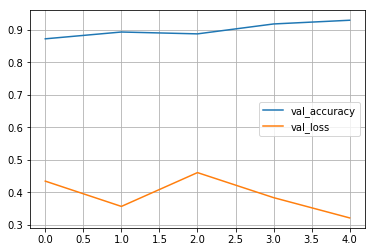

In [36]:
print(history.history['val_accuracy'][-1])
_ = plt.plot(history.history['val_accuracy'], label='val_accuracy')
_ = plt.plot(history.history['val_loss'], label='val_loss')
plt.grid()
_ = plt.legend()

In [270]:
generate_results(model, type='nn')

## CNN

A Convolutional Neural Network is still probably the best technique for machine learning on images. CNNs are feature detectors, they use the proximity of pixels to define features which are aggregated through successive layers of convolutions into higher order features. 

Something like -

edge -> circle -> bodypart -> face

The output from all of this is fed into a normal fully connected feedforward network.

In [39]:
import numpy as np

# The input to our CNN needs a channel. 3 for RGB, but just 1 in our case. We add this with Numpy's expand_dims
X_train_nn = np.expand_dims(X_train_nn.reshape(-1, 28, 28), axis=3)
X_test_nn = np.expand_dims(X_test_nn.reshape(-1, 28, 28), axis=3)
X_train_nn.shape, X_test_nn.shape

((3150, 28, 28, 1), (1050, 28, 28, 1))

In [104]:
from tensorflow.keras.layers import Conv2D, Flatten, MaxPool2D

model = Sequential()

model.add(Conv2D(filters=32, padding='same', input_shape=(X_train_nn.shape[1:]), kernel_size=5))
model.add(MaxPool2D())
model.add(Dropout(rate=.4))

model.add(Conv2D(filters=64, padding='same', kernel_size=5))
model.add(MaxPool2D())
model.add(Dropout(rate=.4))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(rate=.4))

model.add(Dense(10, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [105]:
history = model.fit(X_train_nn, y_train_cat , epochs=20, batch_size=32, validation_data=(X_test_nn, y_test_cat),verbose=1)

Train on 31500 samples, validate on 10500 samples
Epoch 1/20
31500/31500 [==============================] - 49s 2ms/sample - loss: 0.2872 - accuracy: 0.9111 - val_loss: 0.0973 - val_accuracy: 0.9695
Epoch 2/20
31500/31500 [==============================] - 50s 2ms/sample - loss: 0.1297 - accuracy: 0.9603 - val_loss: 0.0638 - val_accuracy: 0.9797
Epoch 3/20
31500/31500 [==============================] - 49s 2ms/sample - loss: 0.1073 - accuracy: 0.9668 - val_loss: 0.0662 - val_accuracy: 0.9818
Epoch 4/20
31500/31500 [==============================] - 50s 2ms/sample - loss: 0.0939 - accuracy: 0.9715 - val_loss: 0.0550 - val_accuracy: 0.9856
Epoch 5/20
31500/31500 [==============================] - 49s 2ms/sample - loss: 0.0910 - accuracy: 0.9722 - val_loss: 0.0510 - val_accuracy: 0.9852
Epoch 6/20
31500/31500 [==============================] - 49s 2ms/sample - loss: 0.0823 - accuracy: 0.9750 - val_loss: 0.0490 - val_accuracy: 0.9864
Epoch 7/20
31500/31500 [==============================] 

0.9695238


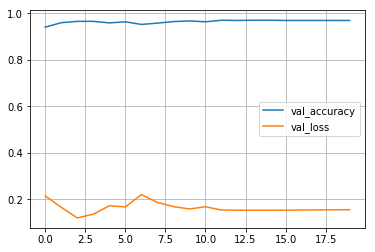

In [89]:
print(history.history['val_accuracy'][-1])
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['val_loss'], label='val_loss')
plt.grid()
plt.legend()

In [106]:
generate_results(model, type='cnn')

So from the history output for the last run you can see a validation accuracy of 98.8%. Pretty impressive for so little code. Overall this took about half an hour to train on my laptop. 
There are many more enhancements that can be made to improve this model. See the list of world class research results on Le Cunn's website. 